## React Agent Architecture

**AIM**\
This is the intuition behind the ReAct, a genera agent architecture

1. act- let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g, call another tool or just respond directly)

In [1]:
## load all the keys
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv('LANGCHAIN_PROJECT')

In [2]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

In [8]:
tavily.invoke("provide the recent AI news for November 3 2025")

{'query': 'provide the recent AI news for November 3 2025',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.artificialintelligence-news.com/',
   'title': 'AI News | Latest AI News, Analysis & Events',
   'content': 'Related News. AI News. November 3, 2025. Qualcomm unveils AI data centre chips to crack the Inference market · AI News. October 31, 2025. How LeapXpert uses AI',
   'score': 0.8891543,
   'raw_content': None},
  {'url': 'https://newsroom.ibm.com/blog-ibm-impact-accelerator-bings-ai-to-the-frontlines-of-supply-chains',
   'title': 'IBM Impact Accelerator Brings AI to the Frontlines of Supply Chains',
   'content': 'Latest News. IBM Impact Accelerator Brings AI to the Frontlines ... | Nov 3, 2025. Artificial intelligence. IBM Announces Defense-Focused',
   'score': 0.8170061,
   'raw_content': None},
  {'url': 'https://markmcneilly.substack.com/p/the-new-news-in-ai-11325-edition',
   'title': 'The New News in AI: 11/3/25 Editio

In [9]:
# Custom functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        int: Returns the product of a and b
    """
    return a * b


def add(a: int, b:int ) -> int:
    """Returns the sum of a and b

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        int: returns the sum of a and b
    """
    return a + b

def divide(a: int, b: int ) -> float:
    """divide a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        float: returns quotient when a divided by b
    """
    return a / b

In [10]:
tools = [arxiv, wiki, add, multiply, divide, tavily]

In [11]:
# Initialize my llm model
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-120b")

# bind toos with llm
llm_with_tools = llm.bind_tools(tools)


In [12]:
from langchain.messages import HumanMessage, AIMessage

result = llm_with_tools.invoke([HumanMessage(content="What is the recent Ai News")])

In [13]:
result.tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'AI news latest week',
   'search_depth': 'advanced',
   'time_range': 'week',
   'topic': 'news'},
  'id': 'fc_57776030-98c2-4c99-b36a-89c621c9516c',
  'type': 'tool_call'}]

### Building the Graph

In [14]:
# State Schema
from pydantic import BaseModel
from typing import Annotated
from langchain.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

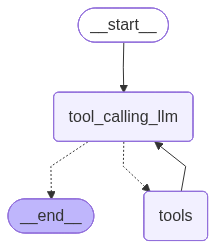

In [15]:
# Build the chatbot
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode, tools_condition


# Node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}
    
# Build the graph
builder = StateGraph(State)

# add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm") # add edge to feed data back to llm

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Provide me the top 10 latest AI news for November 3 2025, add 5 plus 5 and them multiply it by 10")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me the top 10 latest AI news for November 3 2025, add 5 plus 5 and them multiply it by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_303a9638-0eae-4562-b0df-21464637042b)
 Call ID: fc_303a9638-0eae-4562-b0df-21464637042b
  Args:
    query: AI news November 3 2025
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news November 3 2025", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://markets.ft.com/data/announce/detail?dockey=600-202511030159BIZWIRE_USPRX____20251103_BW564089-1", "title": "Europe Seeking Greater AI Sovereignty, Accenture Report Finds – Company Announcement - Financial Times", "score": 0.9296516, "published_date": "Mon, 03 Nov 2025 06:59:00 GMT", "c

### Agent Memory

Lets introduce Agent With Memory

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="What is 5 plus 8")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================

5 + 8 = 13.


In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Divide that by 5")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

I’m not sure which value you’d like to divide by 5. Could you let me know the number (or expression) you want to divide?


### Memory Saver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistance lery gives us memory, allowing LangGraph to pick up from the last state update.
One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.
All we need to do is simply compile the graph with a checkpointer, and our graph has memory.

In [21]:
# Build the chatbot
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode, tools_condition


# Node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}
    
# Build the graph
builder = StateGraph(State)

# add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm") # add edge to feed data back to llm



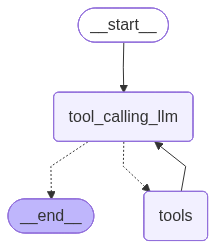

In [23]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [27]:
## specify th thread
config = {"configurable": {"thread_id": "1"}}

# specify an input
messages = graph_memory.invoke({"messages": HumanMessage(content="What is 12 plus 13")}, config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================

12 + 13 = 25.


In [28]:
messages = graph_memory.invoke({"messages": HumanMessage(content="Add that number to 25")}, config=config)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12 plus 13
================================== Ai Message ==================================

12 + 13 = 25.
================================ Human Message =================================

Add that number to 25
================================== Ai Message ==================================

\(25 + 25 = 50\).
